In [2]:
pip install tensorflow tensorflow_datasets

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 5.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 5.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.2 MB/s eta 0:00:0000:0100:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21484 sha256=aa3a5cff46ca92ec71b787cc0ebdd6b07489f440e1b7ba74542ed9ea1d1731c9
  Stored in directory: /home/vscode/.cache/pip/wheels/54/4e/28/3ed0e1c8a752867445bab994d2340724928aa3ab059c57c8db
Successfully built promise
  Attempting uninstall: protobuf
    Found existing installation: protobuf 

In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from flax import linen as nn

2024-11-22 04:07:55.430322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 04:07:55.433813: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 04:07:55.442552: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 04:07:55.467223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732248475.495647   10189 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732248475.50

```bash
!pip install tensorflow tensorflow_datasets
```

# Neural Network on MNIST dataset

Let's revisit the problem of recognizing handwritten digits from the MNIST dataset.  We'll make use of the data currated in `tensorflow_datasets`, which also has lots of convenient methods for splits data, batching, etc.

In [2]:
train_ds = tfds.load('mnist', split='train')
test_ds = tfds.load('mnist', split='test')

2024-11-22 04:08:13.122906: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /home/vscode/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2024-11-22 04:08:18.257104: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
train_ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

These data objects are very efficient with lots convenient methods, but they are a little cumbersome to interact with for simple tasks like plotting an example.

2024-11-22 04:08:53.218833: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-11-22 04:08:53.277873: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(28, 28, 1)


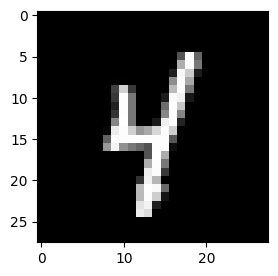

In [4]:
f = plt.figure(figsize=(15,3))

for ex in train_ds.as_numpy_iterator():
    print(ex['image'].shape)
    plt.imshow(ex['image'], cmap='gray')
    break

In [5]:
for example in train_ds.as_numpy_iterator():
    print(example['image'].max())
    break

255


2024-11-22 04:08:58.415680: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Notice that the pixel values imported as an integer array that saturates at $255$.  Let's turn the data into floats $\in [0, 1]$.

In [6]:
train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                        tf.float32) / 255.,
                                        'label': sample['label']}) # normalize train set
test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                        tf.float32) / 255.,
                                    'label': sample['label']}) # normalize test set

In [7]:
tf.random.set_seed(0) # ensure dataset shuffling

We're going to batch the data, and also choose random subsets.  We don't need to train on the whole set in this case.

In [8]:
num_epochs = 10
batch_size = 32

# shuffle data by allocating a buffer of 1024 to randomly draw examples from
train_ds = train_ds.repeat(num_epochs).shuffle(1024)
test_ds = test_ds.shuffle(1024)

# group into batches of 32, skip incomplete batch, prefetch next sample to speed up
train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

Now let's build a neural network.  Let's build a network with two hidden layers with 100 nodes each.  We'll use the *ReLU* activation function (see, e.g., [here](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7) for lots more details).

In [9]:
n_classes = 10

class DenseNN(nn.Module):
  """A simple model with densely connected layers."""

  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))   # flatten
    x = nn.Dense(features=100)(x)
    x = nn.relu(x)
    x = nn.Dense(features=100)(x)
    x = nn.relu(x)
    x = nn.Dense(features=n_classes)(x)
    return x

We can use `.tabulate()` to get a summary of the model.  Remember that we haven't specified the shape of `x` in the model above, meaning it doesn't actually know the date volume shapes (or number of parameters) unless we give it data with the right shape.

In [10]:
import jax
import jax.numpy as jnp  # JAX NumPy

dummy_input = jnp.ones((1, 28, 28, 1))

dnn = DenseNN()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                                DenseNN Summary                                 
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs             ┃ outputs        ┃ params             ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│         │ DenseNN │ float32[1,28,28,1] │ float32[1,10]  │                    │
├─────────┼─────────┼────────────────────┼────────────────┼────────────────────┤
│ Dense_0 │ Dense   │ float32[1,784]     │ float32[1,100] │ bias: float32[100] │
│         │         │                    │                │ kernel:            │
│         │         │                    │                │ float32[784,100]   │
│         │         │                    │                │                    │
│         │         │                    │                │ 78,500 (314.0 KB)  │
├─────────┼─────────┼────────────────────┼────────────────┼────────────────────┤
│ Dense_1 │ Dense   │ float

We need to do a little legwork to setup some object for tracking training metrics (e.g., loss, accuracy).  We'll use the `clu` companion library to make our lives (a little) easier.

In [11]:
pip install clu

/usr/local/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


```bash
!pip install clu
```

In [12]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [13]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

Next we'll create a function that will initial our training state for us.

In [15]:
def create_train_state(model, rng, learning_rate, momentum):
    params = model.init(rng, dummy_input)['params']
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

Finally, let's define functions that will perform a training step (i.e., update parameters based on a batch of training data), and compute training metrics.

In [16]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [17]:
@jax.jit
def compute_metrics(*, state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

Let's create a training state and prepare to train.

In [18]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01
momentum = 0.9

state = create_train_state(dnn, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

We'll track metrics along the way...

In [19]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [20]:
train_ds.cardinality().numpy()

np.int64(18750)

In [21]:
# since train_ds is replicated num_epochs times in get_datasets(), we divide by num_epochs
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs
num_steps_per_epoch

np.int64(1875)

In [22]:
for step,batch in enumerate(train_ds.as_numpy_iterator()):
  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

2024-11-22 04:18:28.282384: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 1, loss: 0.28643739223480225, accuracy: 91.6066665649414
test epoch: 1, loss: 0.14503931999206543, accuracy: 95.53285217285156


2024-11-22 04:18:34.163638: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 2, loss: 0.11035943776369095, accuracy: 96.71833801269531
test epoch: 2, loss: 0.10572691261768341, accuracy: 96.63461303710938
train epoch: 3, loss: 0.07541175931692123, accuracy: 97.81999969482422
test epoch: 3, loss: 0.09046056121587753, accuracy: 97.09535217285156


2024-11-22 04:18:44.272045: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 4, loss: 0.05670257657766342, accuracy: 98.32833099365234
test epoch: 4, loss: 0.08999420702457428, accuracy: 97.275634765625
train epoch: 5, loss: 0.04528406262397766, accuracy: 98.7066650390625
test epoch: 5, loss: 0.07690247148275375, accuracy: 97.57612609863281
train epoch: 6, loss: 0.035231150686740875, accuracy: 99.04000091552734
test epoch: 6, loss: 0.07781115919351578, accuracy: 97.69631958007812
train epoch: 7, loss: 0.0273425430059433, accuracy: 99.25
test epoch: 7, loss: 0.07932793349027634, accuracy: 97.60617065429688


2024-11-22 04:19:05.186307: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 8, loss: 0.02218431793153286, accuracy: 99.4433364868164
test epoch: 8, loss: 0.08483200520277023, accuracy: 97.48597717285156
train epoch: 9, loss: 0.0168004110455513, accuracy: 99.62166595458984
test epoch: 9, loss: 0.07742396742105484, accuracy: 97.74639892578125
train epoch: 10, loss: 0.01414454448968172, accuracy: 99.67832946777344
test epoch: 10, loss: 0.08136056363582611, accuracy: 97.73637390136719


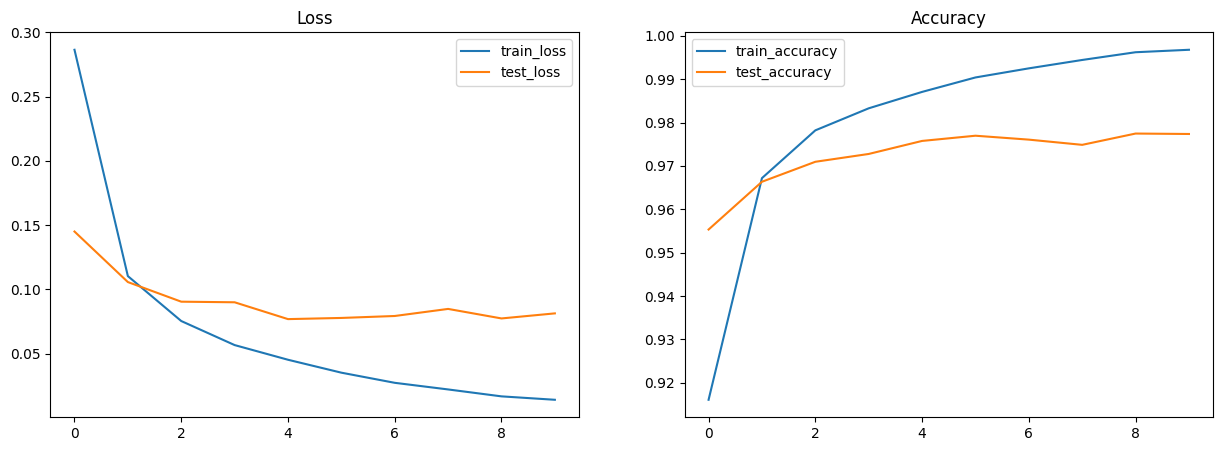

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

Let's see how are model does at predicting specific examples from the test set.

In [24]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'])
  return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

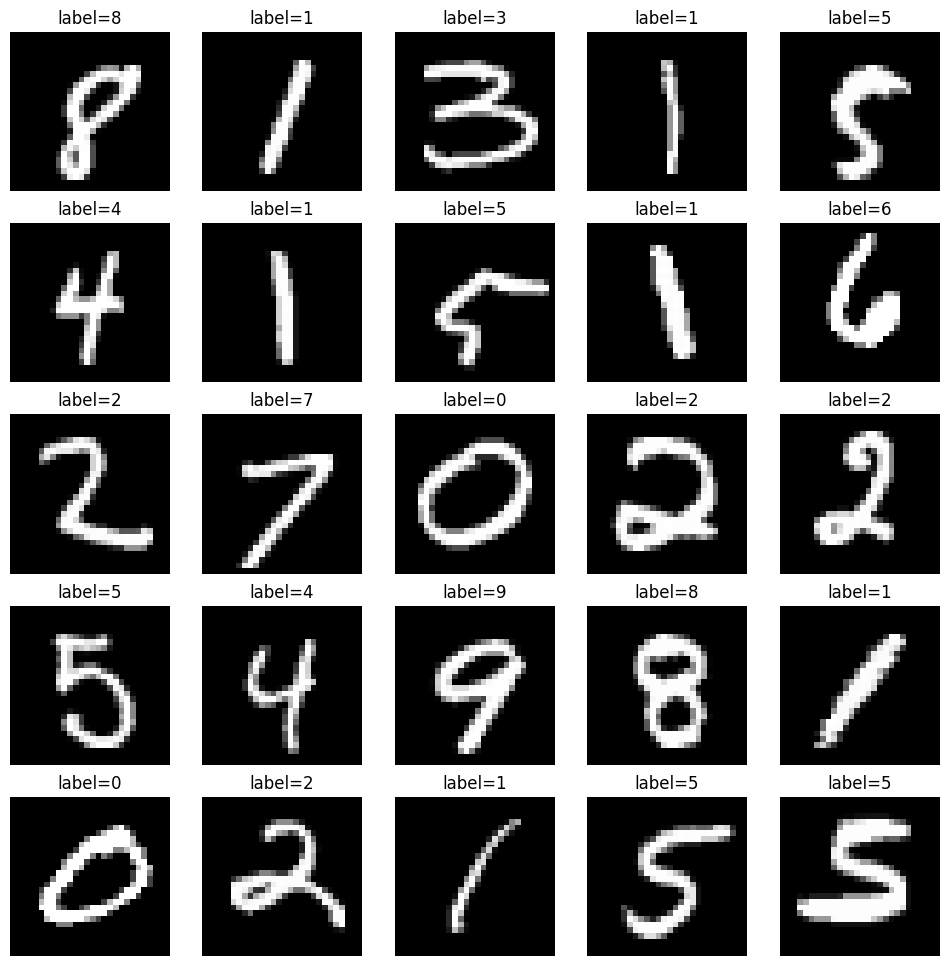

In [25]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={pred[i]}")
    ax.axis('off')

What if we manipulate the data a bit.  Is it easily confused?

In [26]:
new_test_ds = test_ds.map(lambda sample: {'image': tf.roll(sample['image'], 3, 2),
                                          'label': sample['label']})

In [27]:
new_test_ds

<_MapDataset element_spec={'image': TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(32,), dtype=tf.int64, name=None)}>

In [28]:
new_test_batch = new_test_ds.as_numpy_iterator().next()
new_pred = pred_step(state, new_test_batch)

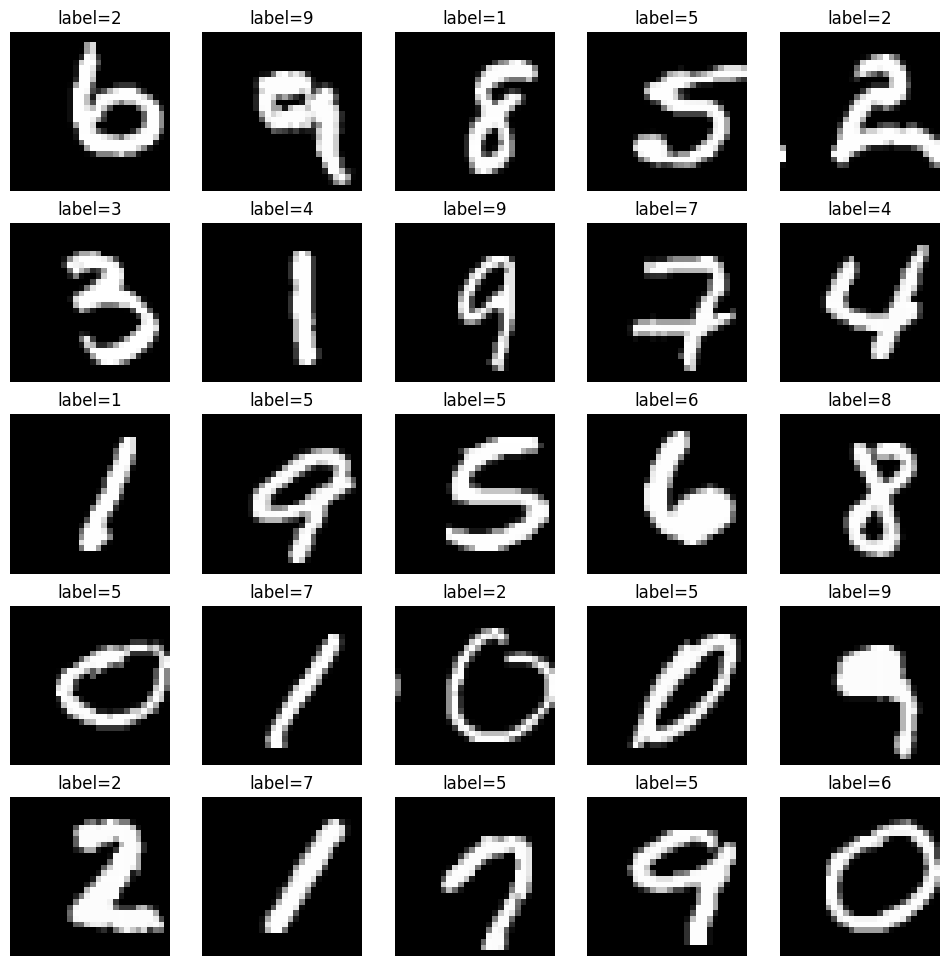

In [29]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(new_test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={new_pred[i]}")
    ax.axis('off')